# FCM inversion by manual re-weighting

In [34]:
import numpy as np
from anisotropic_potential import LayeredHalfspace, apparent_conductivity
from anisotropic_potential_obj import AnisotropicPotentialObjectiveFunction
from objfunc import ModelObjectiveFunction, FCMObjectiveFunction
from utils import eff_anis_trans
import matplotlib.pyplot as plt
from time import time
import scipy.sparse as sp
from scipy.optimize import minimize

from IPython import display

In [37]:
#Setting up model
#sig1 = [10**-0.4, 10**-0.9, 10**-.3]
#sig2 = [10**-0.2, 10**-0.3, 10**-.3]
#sig3 = [10**-0.1, 10**-0.0, 10**-.3]
#alpha = [3*np.pi/20, -np.pi/8, 0]
#betas = [0, -3*np.pi/8, 0]
#gamma = [0, 3*np.pi/8, 0]
#zs = [0, 5, 25]

#Setting up model
sig1 = [10**-0.4, 10**0.0, 10**-.3]
sig2 = [10**-0.1, 10**-.3, 10**-.3]
sig3 = [10**-0.4, 10**-.9, 10**-.3]
alpha = [3*np.pi/20, -np.pi/5, 0]
betas = [0, -3*np.pi/5, 0]
gamma = [0, 3*np.pi/5, 0]
z = [0, 5, 25]

forward_space = LayeredHalfspace(z, sig1, sig2, sig3, alpha, betas, gamma)

#Setting up observation points
wenner_distances= np.array([-3,-1,1,3])
scales = np.logspace(0,4.5,15)

Axs = wenner_distances[0]*scales
Mxs = wenner_distances[1]*scales
Nxs = wenner_distances[2]*scales
Bxs = wenner_distances[3]*scales
Ays = np.zeros_like(Axs)
Bys = np.zeros_like(Bxs)
Mys = np.zeros_like(Mxs)
Nys = np.zeros_like(Nxs)

#Rotations to perform:
rs = np.array([0, np.pi/2])
Xs_a, Ys_a = [],[]
Xs_b, Ys_b = [],[]
Xs_m, Ys_m = [],[]
Xs_n, Ys_n = [],[]
for r in rs:
    rot = np.array([[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]])
    
    x, y = rot@np.c_[Axs, Ays].T
    Xs_a.append(x), Ys_a.append(y)
    
    x, y = rot@np.c_[Bxs, Bys].T
    Xs_b.append(x), Ys_b.append(y)
    
    x, y = rot@np.c_[Mxs, Mys].T
    Xs_m.append(x), Ys_m.append(y)
    
    x, y = rot@np.c_[Nxs, Nys].T
    Xs_n.append(x), Ys_n.append(y)

Ax = np.hstack(Xs_a)
Ay = np.hstack(Ys_a)
Bx = np.hstack(Xs_b)
By = np.hstack(Ys_b)
Mx = np.hstack(Xs_m)
My = np.hstack(Ys_m)
Nx = np.hstack(Xs_n)
Ny = np.hstack(Ys_n)
    
A = np.c_[Ax, Ay].T
B = np.c_[Bx, By].T
M = np.c_[Mx, My].T
N = np.c_[Nx, Ny].T

In [3]:
volts = forward_space.voltage(A, B, M, N)

np.random.seed(1)
d_obs = volts+np.random.randn(*volts.shape)*volts*0.01
Wd = sp.diags(1/(0.01*volts))

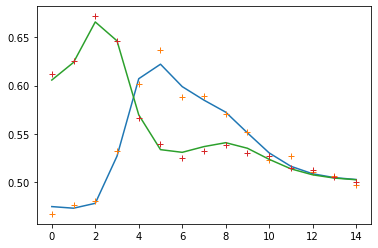

In [4]:
rhoa_true = apparent_conductivity(volts, A, B, M, N)
rhoa_obs = apparent_conductivity(d_obs, A, B, M, N)
for i in range(len(rs)):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')

In [5]:
n_inv_layers = 50
s1 = np.ones(n_inv_layers)*10**-.3
s2 = np.ones(n_inv_layers)*10**-.3
s3 = np.ones(n_inv_layers)*10**-.3
a = np.zeros(n_inv_layers)
b = np.zeros(n_inv_layers)
g = np.zeros(n_inv_layers)
zs = np.logspace(0,3,50)-1 #log spaced widths
dz = zs[1:]-zs[:-1]
dz = np.append(dz,dz[-1])

mref = np.concatenate((np.log(s1), np.log(s2), np.log(s3), a, b, g))
mi = mref.copy()
options = {'disp':True}

In [6]:
PhiD = AnisotropicPotentialObjectiveFunction(zs, (A, B, M, N), d_obs, Wd=Wd)

In [7]:
weights = 1/(np.abs(zs)+1)**2
weights /= weights.max()
weights[-1] = 100
#weights2 = (weights[1:]+weights[:-1])/2

Wz = sp.diags(dz)*sp.diags([-1/dz,1/dz],[0,1],shape=(n_inv_layers,n_inv_layers))
Wz = sp.block_diag([Wz]*3+[Wz]*3).tocsr()
Ws = sp.block_diag([sp.diags(weights*np.sqrt(dz))]*3+[sp.diags(np.sqrt(dz))]*3)

W_anis = sp.diags([-1,-1,2,-1,-1],
                  [-2*n_inv_layers,-n_inv_layers,0,n_inv_layers,2*n_inv_layers],
                  shape=(3*n_inv_layers, 3*n_inv_layers))
W_anis = sp.block_diag((W_anis, sp.csr_matrix(W_anis.shape)))
PhiM = ModelObjectiveFunction(0.25*Ws.T@Ws+100*Wz.T@Wz+1*W_anis, mref=mref)
PhiM2 = ModelObjectiveFunction(100*Wz.T@Wz+1*W_anis, mref=mref)

In [8]:
def callback(x):
    print(Phi(x), PhiD(x), PhiM(x))

In [9]:
mod_folder = "models/cross/"

# Smooth Inversion
start with a smooth inversion to find $\beta$

In [11]:
beta = 50
Phi = PhiD+beta*PhiM

x = mi
callback(x)
out = minimize(Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta50_x',x)

5736.352692416266 5736.352692416266 0.0
994.4832795664768 732.9703556552221 5.2302584782250925
675.0239002103173 371.55008566517665 6.069476290902813
628.169051136791 303.02140840498964 6.502952854636027
605.4199034955584 259.0454290734198 6.927489488442772
603.4151972359987 265.2784322324472 6.7627353000710295
603.1946246190994 267.596947947692 6.711953533428147
602.9622839226969 269.8514928328706 6.662215821796526
602.9334445680781 268.34074754946164 6.691853940372329
602.9269723483387 268.75171409222247 6.683505165122327
602.9264890050633 268.59206301684236 6.686688519764418
602.9262316456036 268.53227867412716 6.68787905942953
602.9261857201745 268.60542560304077 6.686415202342677
Optimization terminated successfully.
         Current function value: 602.926186
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
         Hessian evaluations: 105
PhiD: 268.60542560304077


In [14]:
beta = 10
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta50_x.npy')
callback(x)
out = minimize(Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1E-4)
x = out['x']
print('PhiD:', PhiD(x))

np.save(mod_folder + 'beta10_x',x)

335.4695776264675 268.60542560304077 6.686415202342677
268.4974315045494 160.44517373286317 10.805225777168623
240.33992110210764 107.31722971414536 13.302269138796229
236.30133079080147 97.8297679392494 13.847156285155208
235.01928614793044 95.63282663861258 13.938645950931786
234.57257826697935 92.27586487176212 14.22967133952172
234.50182972335196 93.44783711951428 14.10539926038377
234.49605563142535 93.47587514867728 14.102018048274806
Optimization terminated successfully.
         Current function value: 234.496056
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 56
PhiD: 93.47587514867728


In [15]:
beta = 5
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta10_x.npy')
callback(x)
out = minimize(Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1e-4)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta5_x',x)

163.98596539005132 93.47587514867728 14.102018048274806
158.47292119575872 76.1446178434833 16.46566067045508
157.14148163759234 74.66751436399451 16.494793454719563
155.72468058214383 66.17272478731792 17.910391158965187
155.3499896897764 63.08985667551771 18.45202660285174
155.21029150576885 64.3467731537652 18.17270367040073
155.19089162892234 64.13017440125387 18.212143445533695
155.18523694097823 64.11481075769052 18.214085236657542
155.1841877259129 64.08450965427645 18.21993561432729
Optimization terminated successfully.
         Current function value: 155.184188
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 90
PhiD: 64.08450965427645


In [16]:
beta = 2
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta5_x.npy')
print(Phi(x), PhiD(x), PhiM(x))
out = minimize(Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1e-4)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta2_x',x)

100.52438088293103 64.08450965427645 18.21993561432729
100.40395243426929 63.68886751963739 18.35754245731595
Optimization terminated successfully.
         Current function value: 100.403952
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1
PhiD: 63.68886751963739


In [17]:
beta = 1
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta2_x.npy')
print(Phi(x), PhiD(x), PhiM(x))
out = minimize(Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1e-4)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta1_x',x)

82.04640997695334 63.68886751963739 18.35754245731595
71.60366027282363 46.96206073042329 24.641599542400346
65.6313562697437 34.13182140520831 31.49953486453539
64.2814320538807 31.147620056447483 33.13381199743323
63.869042011889285 30.513865230734133 33.35517678115515
63.5762804185059 30.31596885920835 33.26031155929755
63.44403394937445 30.27190243189147 33.17213151748298
63.40691436110796 30.22263033304783 33.18428402806013
63.32055002290117 30.0157406662628 33.30480935663837
63.30022802508214 29.984442681755098 33.31578534332704
Optimization terminated successfully.
         Current function value: 63.300228
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 149
PhiD: 29.984442681755098


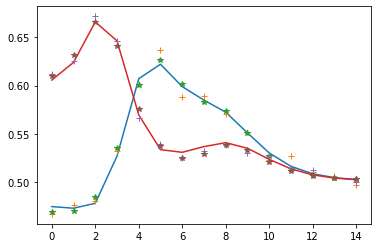

In [18]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
plt.plot(rhoa_true[:15])
plt.plot(rhoa_obs[:15],'+')
plt.plot(rhoa_pre[:15],'*')
plt.plot(rhoa_true[15:])
plt.plot(rhoa_obs[15:],'+')
plt.plot(rhoa_pre[15:],'*')

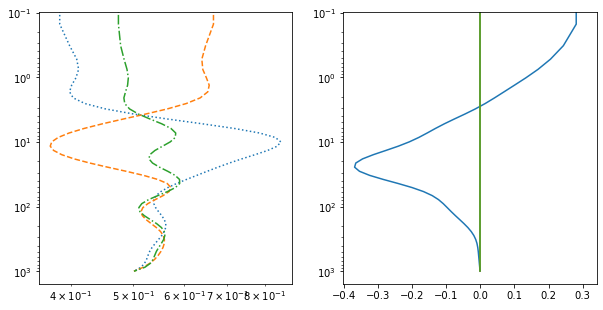

In [19]:
inv1 = np.exp(x.reshape(6,n_inv_layers)[0])
inv2 = np.exp(x.reshape(6,n_inv_layers)[1])
inv3 = np.exp(x.reshape(6,n_inv_layers)[2])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(inv1, zs,':')
plt.loglog(inv2, zs,"--")
plt.loglog(inv3, zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(x.reshape(6, n_inv_layers)[3], zs)
plt.semilogy(x.reshape(6, n_inv_layers)[4], zs)
plt.semilogy(x.reshape(6, n_inv_layers)[5], zs)
plt.gca().invert_yaxis()

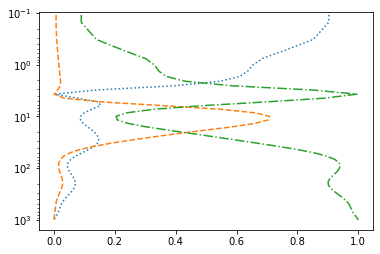

In [10]:
log10 = np.log(10)
tk = np.array([[-0.4*log10, -0.1*log10, -0.4*log10, 3*np.pi/20, 0, 0],
               [0.0*log10, -0.3*log10, -0.9*log10, -np.pi/5, -3*np.pi/5, 3*np.pi/5],
               [-0.3*log10, -0.3*log10, -0.3*log10, 0, 0, 0]])
vi = tk.copy()
xi = np.load(mod_folder + 'beta1_x.npy')

eta = 10000
lamb = 10

PhiFCM = FCMObjectiveFunction(tk, eta, w=np.array([500,1,1,100,1,1]))
u=PhiFCM.updateU(xi, vi)

inv1 = PhiFCM.u[0]
inv2 = PhiFCM.u[1]
inv3 = PhiFCM.u[2]
plt.semilogy(inv1, zs,':')
plt.semilogy(inv2, zs,"--")
plt.semilogy(inv3, zs,"-.")
plt.gca().invert_yaxis()

In [11]:
beta = 1.0
Phi = PhiD + beta*PhiM2 + lamb*PhiFCM

phimkm1 = PhiM(xi)
for i in range(50):
    print('Iteration', i+1)
    PhiFCM.update(xi)
    out = minimize(Phi, xi.reshape(-1), method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
                   callback=lambda x: print(Phi(x)), tol=1E-2)
    xi = out['x']
    phimk = PhiM(xi)
    if(np.abs(phimk-phimkm1)/phimkm1<1E-5):
        break
    phimkm1 = phimk

Iteration 1
4243.547577554456
3669.2752246930395
3590.6131404302096
3526.1821407029443
3485.460185468106
3482.761998746033
Iteration 2
1516.3051084824574
Iteration 3
939.5364501897135
Iteration 4
775.791491611682
Iteration 5
698.2174986132761
682.5297008629825
Iteration 6
668.4188917206311
664.968373354295
663.3558319593396
Iteration 7
662.7927651922305
Iteration 8
662.4219494559227
Iteration 9
662.3899963626009
Iteration 10
662.368339110426
Iteration 11
662.3654236303197
Iteration 12
662.3642654678713
Iteration 13
662.3630122468603
Iteration 14
662.3628254976426
Iteration 15
662.3627840004264
Iteration 16
662.3627712630479
Iteration 17
662.3627657856168


In [12]:
np.save(mod_folder + 'm_fcm1_x',xi)
PhiD(xi), PhiM2(xi), PhiFCM(xi), Phi(xi)

(56.49402283474076, 258.3706778718735, 34.74980650790025, 662.3627657856168)

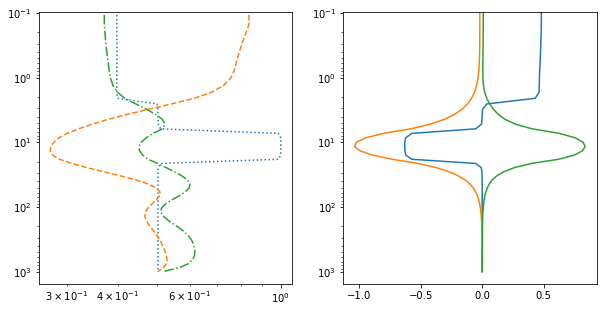

In [13]:
inv1 = np.exp(xi.reshape(6,n_inv_layers)[0])
inv2 = np.exp(xi.reshape(6,n_inv_layers)[1])
inv3 = np.exp(xi.reshape(6,n_inv_layers)[2])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(inv1, zs,':')
plt.loglog(inv2, zs,"--")
plt.loglog(inv3, zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(xi.reshape(6, n_inv_layers)[3], zs)
plt.semilogy(xi.reshape(6, n_inv_layers)[4], zs)
plt.semilogy(xi.reshape(6, n_inv_layers)[5], zs)
plt.gca().invert_yaxis()

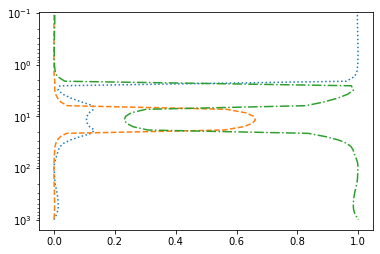

In [14]:
log10 = np.log(10)
tk = np.array([[-0.4*log10, -0.1*log10, -0.4*log10, 3*np.pi/20, 0, 0],
               [0.0*log10, -0.3*log10, -0.9*log10, -np.pi/5, -3*np.pi/5, 3*np.pi/5],
               [-0.3*log10, -0.3*log10, -0.3*log10, 0, 0, 0]])
vi = tk.copy()
xi = np.load(mod_folder + 'm_fcm1_x.npy')

eta = 10000
lamb = 100

PhiFCM = FCMObjectiveFunction(tk, eta, w=np.array([10,1,1,10,1,1]))
u=PhiFCM.updateU(xi, vi)

inv1 = PhiFCM.u[0]
inv2 = PhiFCM.u[1]
inv3 = PhiFCM.u[2]
plt.semilogy(inv1, zs,':')
plt.semilogy(inv2, zs,"--")
plt.semilogy(inv3, zs,"-.")
plt.gca().invert_yaxis()

In [15]:
beta = 1.0
Phi = PhiD+beta*PhiM2+lamb*PhiFCM

phimkm1 = PhiM(xi)
for i in range(50):
    print('Iteration', i+1)
    PhiFCM.update(xi)
    out = minimize(Phi, xi.reshape(-1), method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
                   callback=lambda x: print(Phi(x)), tol=1E-2)
    xi = out['x']
    phimk = PhiM(xi)
    if(np.abs(phimk-phimkm1)/phimkm1<1E-5):
        break
    phimkm1 = phimk

Iteration 1
2153.5784308183647
2072.212947986967
1969.380118556929
1794.392636685494
1683.011061116737
1655.8587081364176
1646.5256437815276
Iteration 2
1255.0380526092617
1245.9244809969382
Iteration 3
1179.3809833111309
Iteration 4
1157.7201960130124
Iteration 5
1126.4524869665902
Iteration 6
1097.337104217665
Iteration 7
1078.5356728128827
Iteration 8
1072.7702610010417
Iteration 9
1071.7848119121954
Iteration 10
1071.6207716417507
Iteration 11
1071.5900350285847
Iteration 12
1071.584114729507
Iteration 13
1071.5829239890543
Iteration 14
1071.5826685031138
Iteration 15
1071.5826113330281
Iteration 16
1071.582588135775
Iteration 17
1071.5825834214113
Iteration 18
1071.5825824342307


In [17]:
np.save(mod_folder + 'm_fcm2_x.npy',xi)

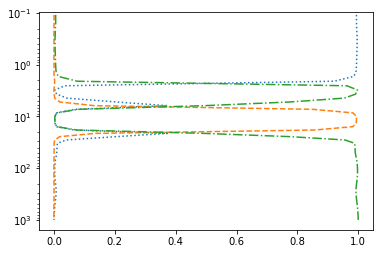

In [18]:
log10 = np.log(10)
tk = np.array([[-0.4*log10, -0.1*log10, -0.4*log10, 3*np.pi/20, 0, 0],
               [0.0*log10, -0.3*log10, -0.9*log10, -np.pi/5, -3*np.pi/5, 3*np.pi/5],
               [-0.3*log10, -0.3*log10, -0.3*log10, 0, 0, 0]])
vi = tk.copy()
xi = np.load(mod_folder + 'm_fcm2_x.npy')

eta = 10000
lamb = 100

PhiFCM = FCMObjectiveFunction(tk, eta, w=np.array([1,1,1,1,1,1]))
u=PhiFCM.updateU(xi, vi)

inv1 = PhiFCM.u[0]
inv2 = PhiFCM.u[1]
inv3 = PhiFCM.u[2]
plt.semilogy(inv1, zs,':')
plt.semilogy(inv2, zs,"--")
plt.semilogy(inv3, zs,"-.")
plt.gca().invert_yaxis()

In [19]:
beta = 1.0
Phi = PhiD+beta*PhiM2+lamb*PhiFCM

phimkm1 = PhiM(xi)
for i in range(50):
    print('Iteration', i+1)
    PhiFCM.update(xi)
    out = minimize(Phi, xi.reshape(-1), method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
                   callback=lambda x: print(Phi(x)), tol=1E-2)
    xi = out['x']
    phimk = PhiM(xi)
    if(np.abs(phimk-phimkm1)/phimkm1<1E-5):
        break
    phimkm1 = phimk

Iteration 1
877.1275620542606
875.029986298691
Iteration 2
866.8886554041214
Iteration 3
865.6283719423989
Iteration 4
865.2050845761767
Iteration 5
864.9247821481125
Iteration 6
864.7197280931189
Iteration 7
864.5664877492868
Iteration 8
864.4496599213088
Iteration 9
864.3598554813648
Iteration 10
864.2905378706391
Iteration 11
864.2360839896535
Iteration 12
864.1928429897185
Iteration 13
864.1579854043368
Iteration 14
864.1293270520673
Iteration 15
864.1058264463035
Iteration 16
864.0863805608676
Iteration 17
864.0700248318724
Iteration 18
864.0560744223592
Iteration 19
864.0440786043573
Iteration 20
864.0336756417593
Iteration 21
864.0246111481354
Iteration 22
864.0165572653813
Iteration 23
864.0093170979264
Iteration 24
864.0027701915608
Iteration 25
863.9968778545474
Iteration 26
863.991519273839
Iteration 27
863.9865955460054
Iteration 28
863.9820265181925
Iteration 29
863.9777866739141
Iteration 30
863.9738277092381
Iteration 31
863.9700681221985
Iteration 32
863.9664682104656
I

In [20]:
np.save(mod_folder + 'm_fcm3_x',xi)

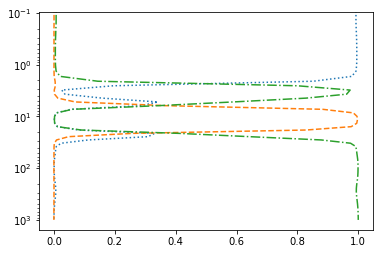

In [21]:
log10 = np.log(10)
tk = np.array([[-0.4*log10, -0.1*log10, -0.4*log10, 3*np.pi/20, 0, 0],
               [0.0*log10, -0.3*log10, -0.9*log10, -np.pi/5, -3*np.pi/5, 3*np.pi/5],
               [-0.3*log10, -0.3*log10, -0.3*log10, 0, 0, 0]])
vi = tk.copy()
xi = np.load(mod_folder + 'm_fcm3_x.npy')

eta = 10000
lamb = 200

PhiFCM = FCMObjectiveFunction(tk, eta, w=np.array([1,1,1,1,1,1]))
u=PhiFCM.updateU(xi, vi)

inv1 = PhiFCM.u[0]
inv2 = PhiFCM.u[1]
inv3 = PhiFCM.u[2]
plt.semilogy(inv1, zs,':')
plt.semilogy(inv2, zs,"--")
plt.semilogy(inv3, zs,"-.")
plt.gca().invert_yaxis()

In [22]:
beta = 1.0
Phi = PhiD+beta*PhiM2+lamb*PhiFCM

phimkm1 = PhiM(xi)
for i in range(50):
    print('Iteration', i+1)
    PhiFCM.update(xi)
    out = minimize(Phi, xi.reshape(-1), method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
                   callback=lambda x: print(Phi(x)), tol=1E-2)
    xi = out['x']
    phimk = PhiM(xi)
    if(np.abs(phimk-phimkm1)/phimkm1<1E-5):
        break
    phimkm1 = phimk

Iteration 1
1199.675453412688
1196.3936290036165
Iteration 2
1177.1637086089013
Iteration 3
1172.5068614371958
Iteration 4
1168.996692110189
Iteration 5
1165.7996858863362
Iteration 6
1163.2145158600304
Iteration 7
1161.4787568833515
Iteration 8
1160.5127485979556
Iteration 9
1160.0479518481911
Iteration 10
1159.8474835816028
Iteration 11
1159.7668871744322
Iteration 12
1159.7357347257762
Iteration 13
1159.7239953396866
Iteration 14
1159.7195077523807
Iteration 15
1159.7178442032564
Iteration 16
1159.717221358006
Iteration 17
1159.7169872370314
Iteration 18
1159.7168996463006
Iteration 19
1159.716867061672
Iteration 20
1159.7168545818213
Iteration 21
1159.716849885844
Iteration 22
1159.7168481159451


In [23]:
PhiFCM.v,tk

(array([[-9.21039467e-01, -2.30288857e-01, -9.21054205e-01,
          4.71222373e-01, -1.74197264e-05,  1.93953994e-05],
        [-2.64166979e-05, -6.90735257e-01, -2.07225715e+00,
         -6.28258632e-01, -1.88486336e+00,  1.88488571e+00],
        [-6.90687982e-01, -6.90748405e-01, -6.90762124e-01,
          1.09381524e-06, -7.38495378e-05,  8.31894981e-05]]),
 array([[-0.92103404, -0.23025851, -0.92103404,  0.4712389 ,  0.        ,
          0.        ],
        [ 0.        , -0.69077553, -2.07232658, -0.62831853, -1.88495559,
          1.88495559],
        [-0.69077553, -0.69077553, -0.69077553,  0.        ,  0.        ,
          0.        ]]))

In [24]:
np.save(mod_folder + 'm_fcm_final_x',xi)
PhiD(xi)

34.392152630401085

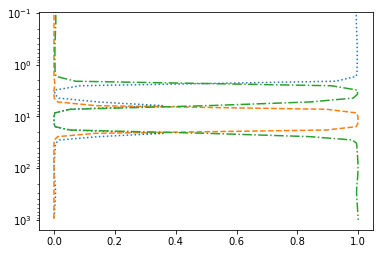

In [25]:
inv1 = PhiFCM.u[0]
inv2 = PhiFCM.u[1]
inv3 = PhiFCM.u[2]
plt.semilogy(inv1, zs,':')
plt.semilogy(inv2, zs,"--")
plt.semilogy(inv3, zs,"-.")
plt.gca().invert_yaxis()

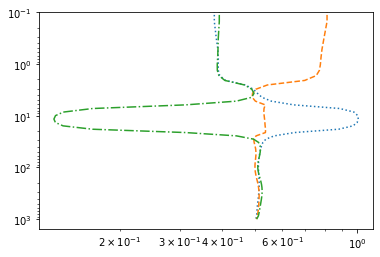

In [26]:
inv1 = np.exp(xi.reshape(6,n_inv_layers)[0])
inv2 = np.exp(xi.reshape(6,n_inv_layers)[1])
inv3 = np.exp(xi.reshape(6,n_inv_layers)[2])
plt.loglog(inv1, zs,':')
plt.loglog(inv2, zs,"--")
plt.loglog(inv3, zs,"-.")
plt.gca().invert_yaxis()

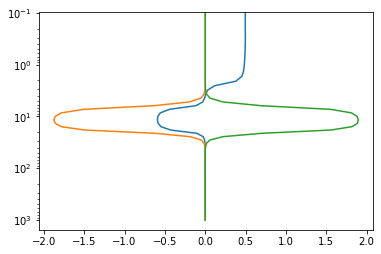

In [27]:
plt.semilogy(xi.reshape(6, n_inv_layers)[3], zs)
plt.semilogy(xi.reshape(6, n_inv_layers)[4], zs)
plt.semilogy(xi.reshape(6, n_inv_layers)[5], zs)
plt.gca().invert_yaxis()

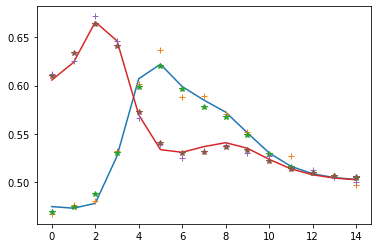

In [28]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
plt.plot(rhoa_true[:15])
plt.plot(rhoa_obs[:15],'+')
plt.plot(rhoa_pre[:15],'*')
plt.plot(rhoa_true[15:])
plt.plot(rhoa_obs[15:],'+')
plt.plot(rhoa_pre[15:],'*')

In [30]:
def plot_model(xi, u, i):

    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    inv1 = np.exp(xi.reshape(6,n_inv_layers)[0])
    inv2 = np.exp(xi.reshape(6,n_inv_layers)[1])
    inv3 = np.exp(xi.reshape(6,n_inv_layers)[2])
    plt.loglog(inv1, zs,':')
    plt.loglog(inv2, zs,"--")
    plt.loglog(inv3, zs,"-.")
    plt.gca().invert_yaxis()

    plt.subplot(1,3,2)
    plt.semilogy(xi.reshape(6, n_inv_layers)[3], zs,":")
    plt.semilogy(xi.reshape(6, n_inv_layers)[4], zs,"--")
    plt.semilogy(xi.reshape(6, n_inv_layers)[5], zs,"-.")
    plt.gca().invert_yaxis()
    plt.title('Iteration {}'.format(i+1))

    plt.subplot(1,3,3)
    inv1 = u[0]
    inv2 = u[1]
    inv3 = u[2]
    plt.semilogy(inv1, zs,':')
    plt.semilogy(inv2, zs,"--")
    plt.semilogy(inv3, zs,"-.")
    plt.gca().invert_yaxis()

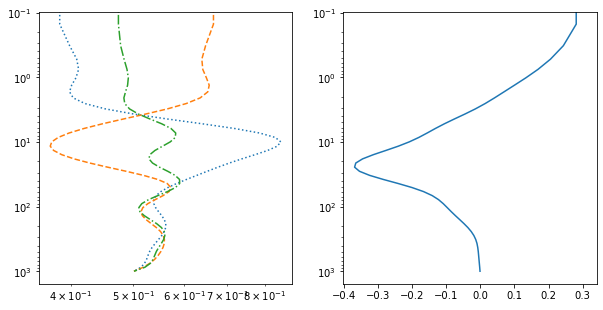

In [48]:
x = np.load(mod_folder + 'beta1_x.npy')
# Plot Effective Anisotropy:
mod = x.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = eff_anis_trans(*mod)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zs,':')
plt.loglog(m_eff[1], zs,"--")
plt.loglog(m_eff[2], zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zs)
plt.gca().invert_yaxis()

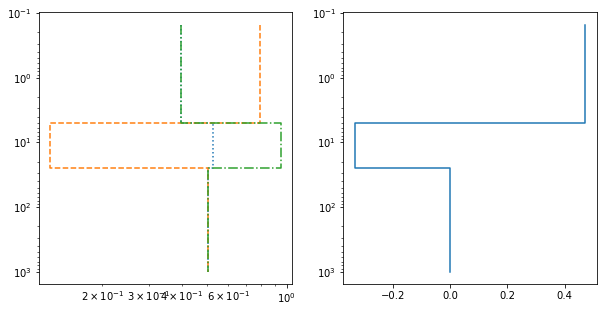

In [49]:
# Plot Effective Anisotropy:

zplot = np.array([zs[1],z[1],z[1],z[2],z[2],zs[-1]])
s1plot = np.array([sig1[0],sig1[0],sig1[1],sig1[1],sig1[2],sig1[2]])
s2plot = np.array([sig2[0],sig2[0],sig2[1],sig2[1],sig2[2],sig2[2]])
s3plot = np.array([sig3[0],sig3[0],sig3[1],sig3[1],sig3[2],sig3[2]])
aplot = np.array([alpha[0],alpha[0],alpha[1],alpha[1],alpha[2],alpha[2]])
bplot = np.array([betas[0],betas[0],betas[1],betas[1],betas[2],betas[2]])
gplot = np.array([gamma[0],gamma[0],gamma[1],gamma[1],gamma[2],gamma[2]])

m_eff = eff_anis_trans(s1plot, s2plot, s3plot, aplot, bplot, gplot)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zplot,':')
plt.loglog(m_eff[1], zplot,"--")
plt.loglog(m_eff[2], zplot,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zplot)
plt.gca().invert_yaxis()

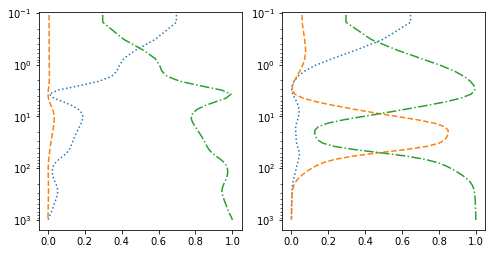

In [56]:
xi = x
log10 = np.log(10)
tk = np.array([[-0.4*log10, -0.1*log10, -0.4*log10, 3*np.pi/20, 0, 0],
               [0.0*log10, -0.3*log10, -0.9*log10, -np.pi/5, -3*np.pi/5, 3*np.pi/5],
               [-0.3*log10, -0.3*log10, -0.3*log10, 0, 0, 0]])
v = tk
PhiFCM = FCMObjectiveFunction(tk, 0)
for i in range(1):
    u = PhiFCM.updateU(xi, v)
    v = PhiFCM.updateV(xi, u, 0)
v_eff = v.copy()
v_eff[:,:3] = np.exp(v_eff[:,:3])
v_eff = np.c_[eff_anis_trans(*v_eff.T)]
v_eff[:, :3] = np.log(v_eff[:,:3])

tk_eff = tk.copy()
tk_eff[:,:3] = np.exp(tk_eff[:,:3])
tk_eff = np.c_[eff_anis_trans(*tk_eff.T)]
tk_eff[:, :3] = np.log(tk_eff[:,:3])

mod = xi.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = np.r_[eff_anis_trans(*mod)].reshape(4, -1)
m_eff[:3] = np.log(m_eff[:3])
m_eff = m_eff.reshape(-1)

eta = 2

PhiFCM = FCMObjectiveFunction(tk, eta, vi=v, w=[1,1,1,1,1,1])
PhiFCM_eff = FCMObjectiveFunction(tk_eff, eta,  w=np.array([0.01,0.01,0.01,1]))

u = PhiFCM.updateU(xi, tk)
u_eff = PhiFCM_eff.updateU(m_eff, tk_eff)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.semilogy(u[0], zs,':')
plt.semilogy(u[1], zs,"--")
plt.semilogy(u[2], zs,"-.")
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.semilogy(u_eff[0], zs,':')
plt.semilogy(u_eff[1], zs,"--")
plt.semilogy(u_eff[2], zs,"-.")
plt.gca().invert_yaxis()

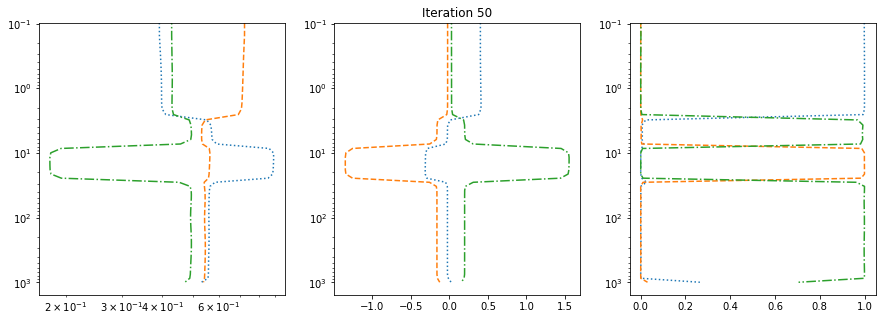

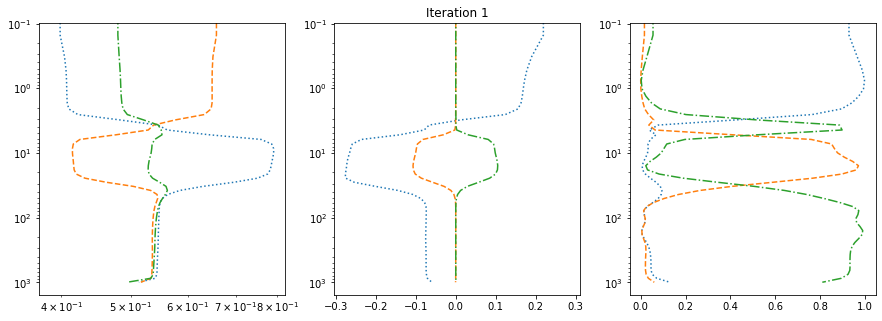

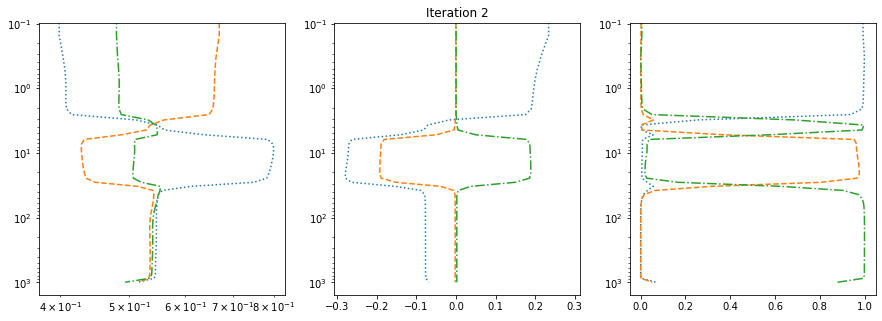

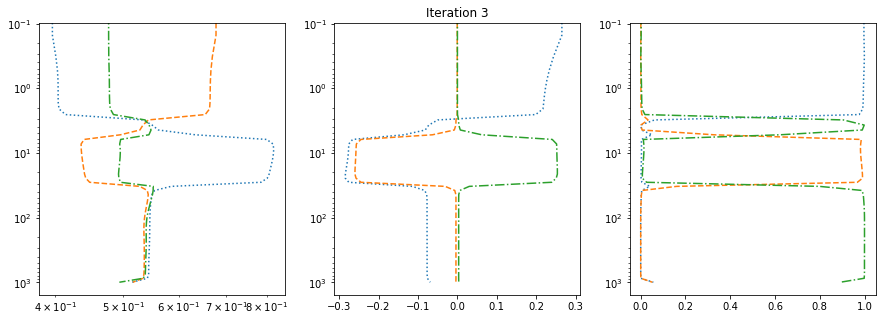

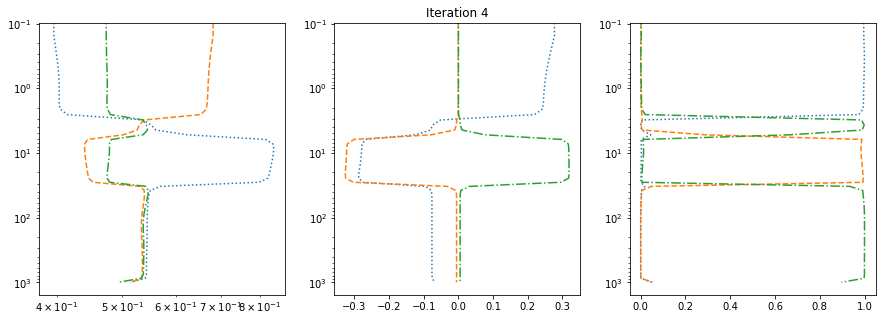

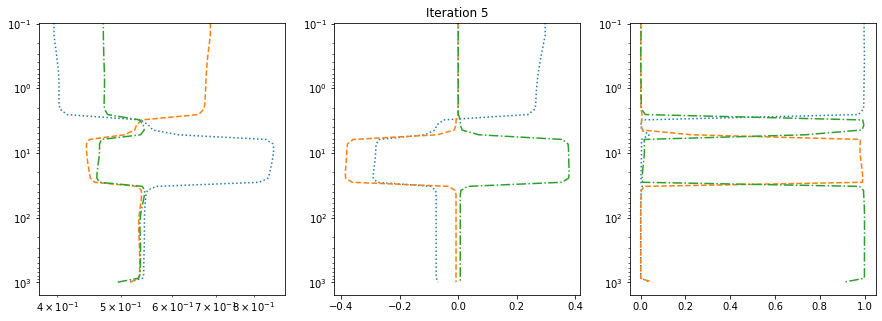

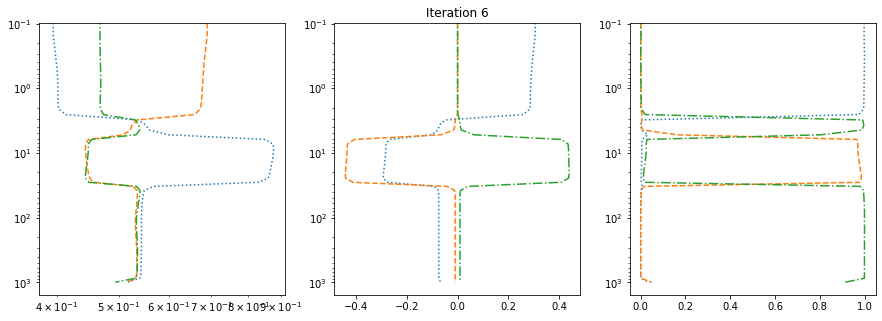

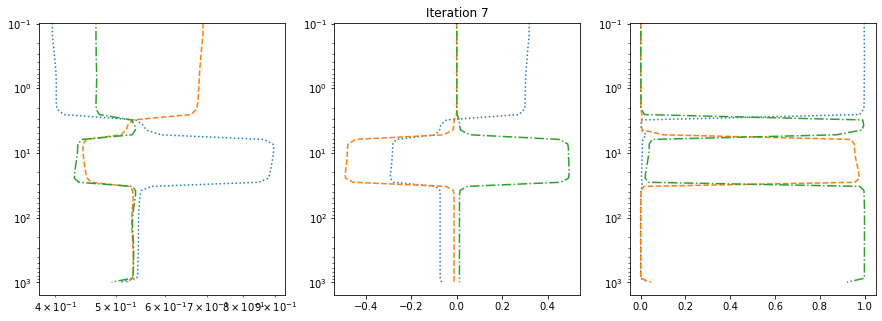

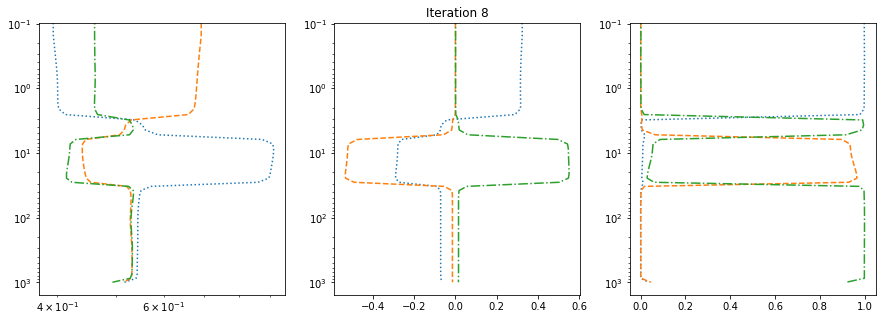

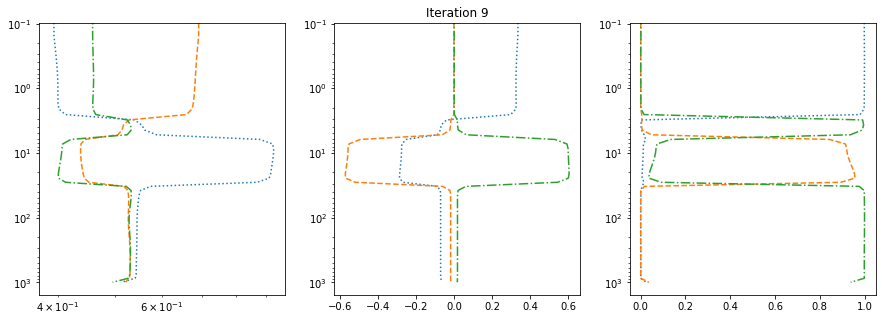

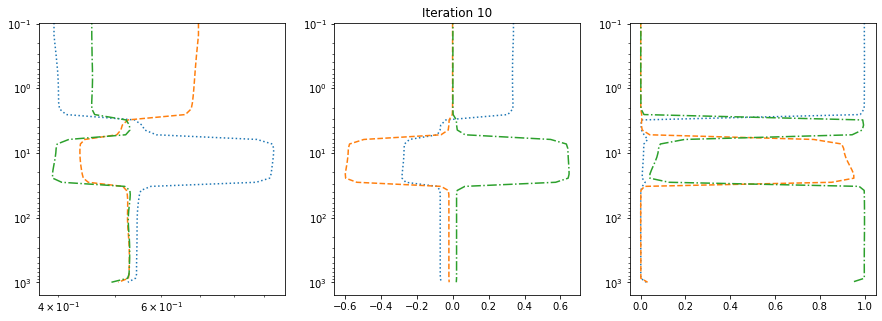

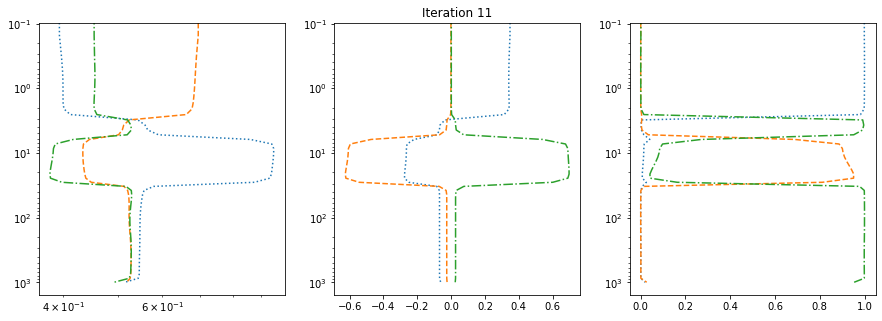

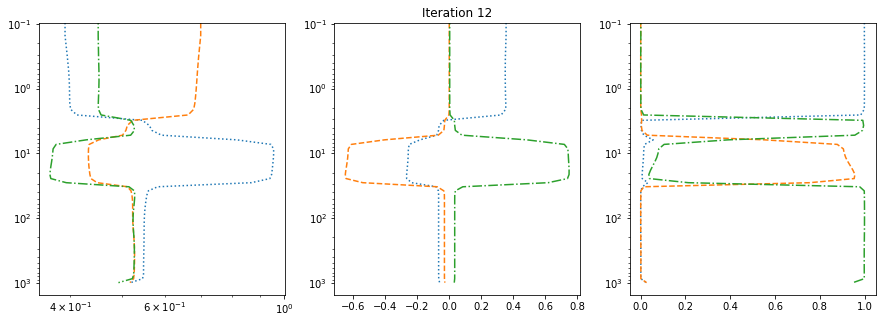

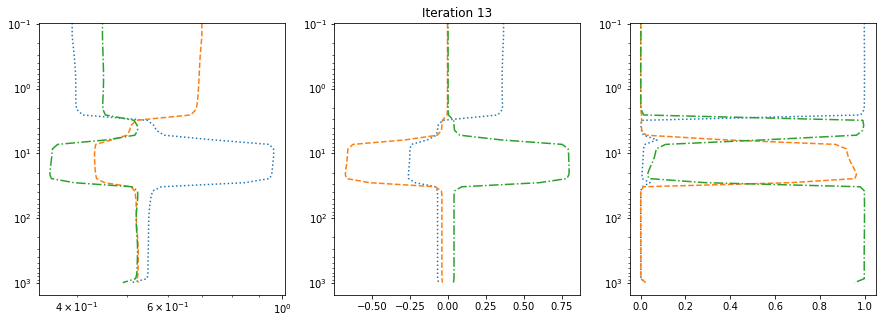

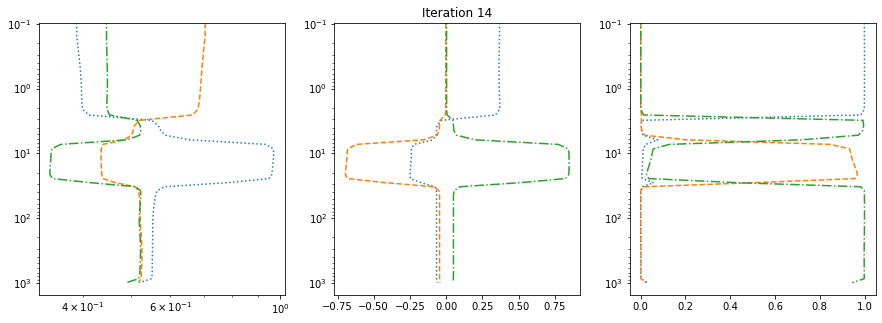

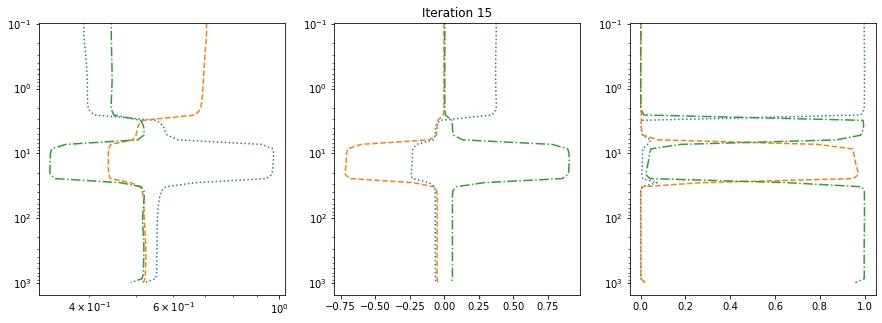

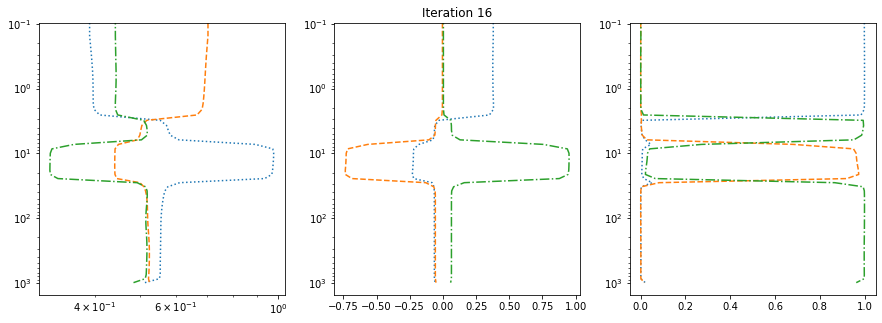

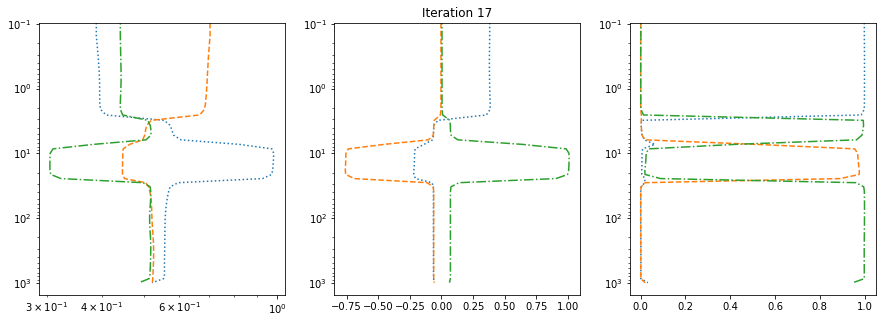

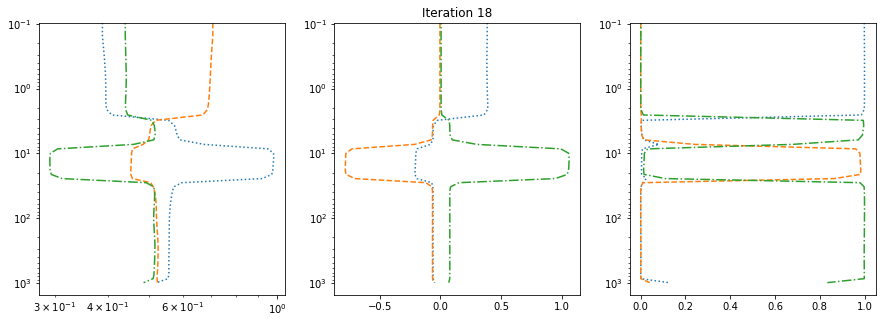

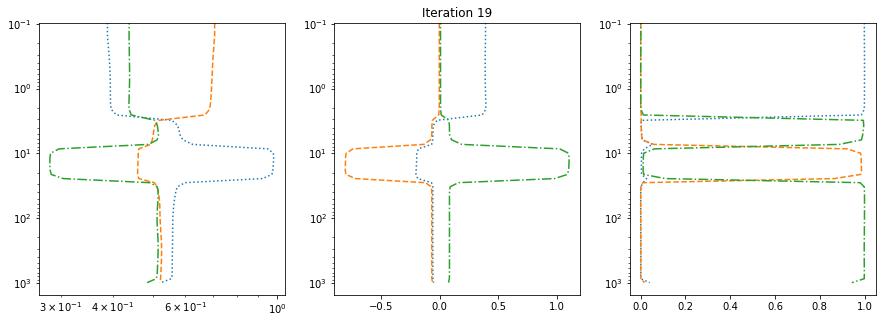

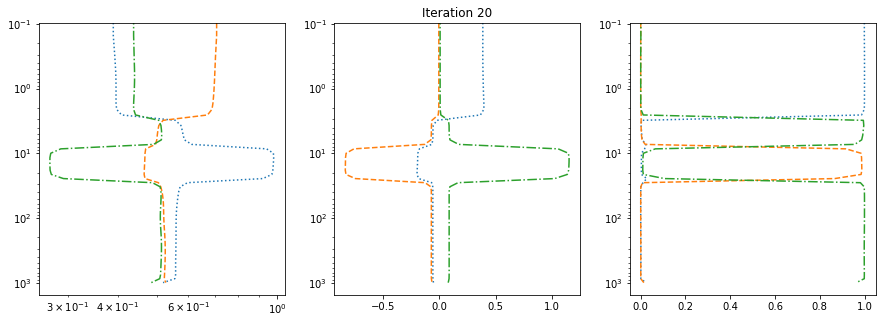

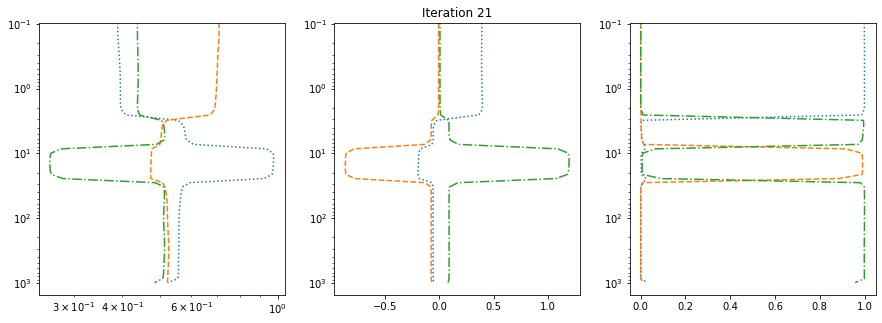

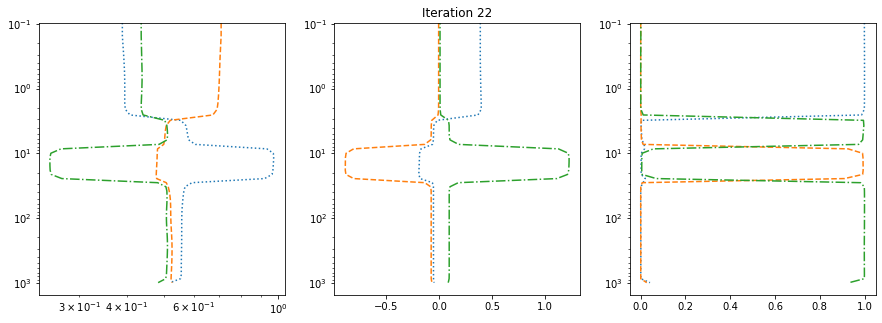

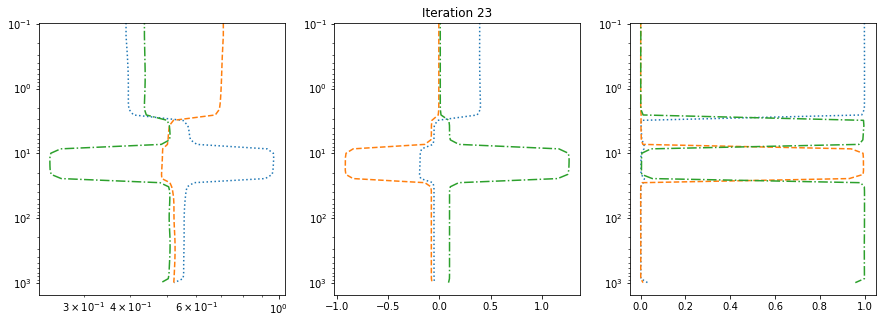

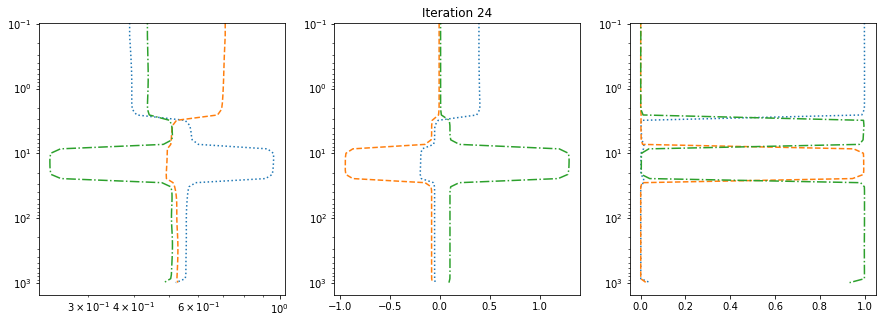

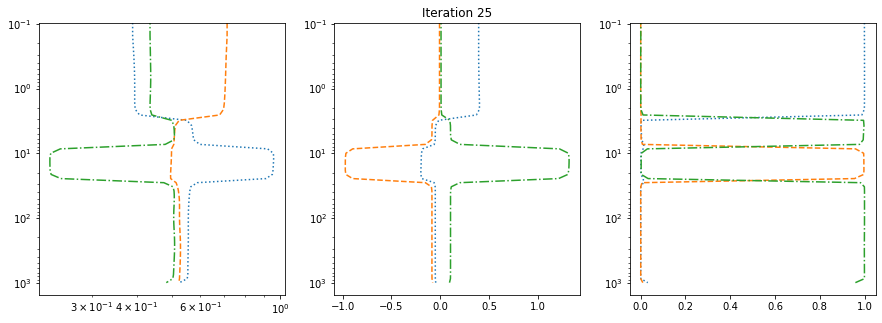

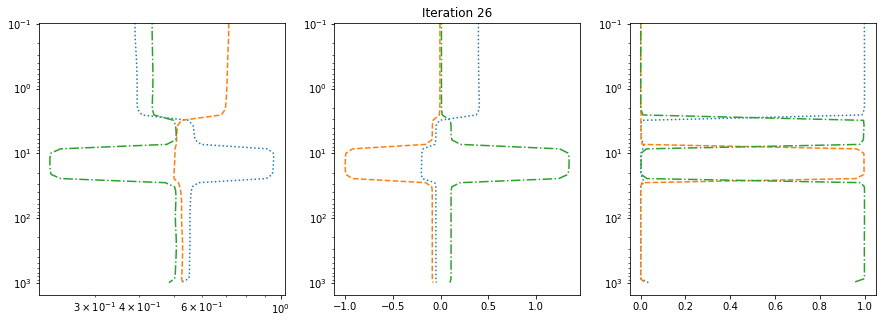

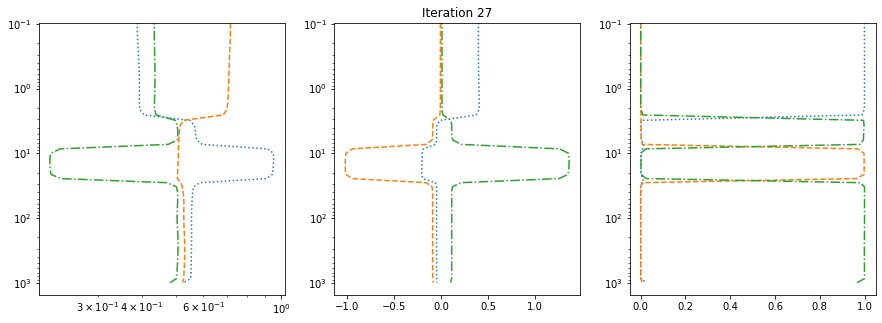

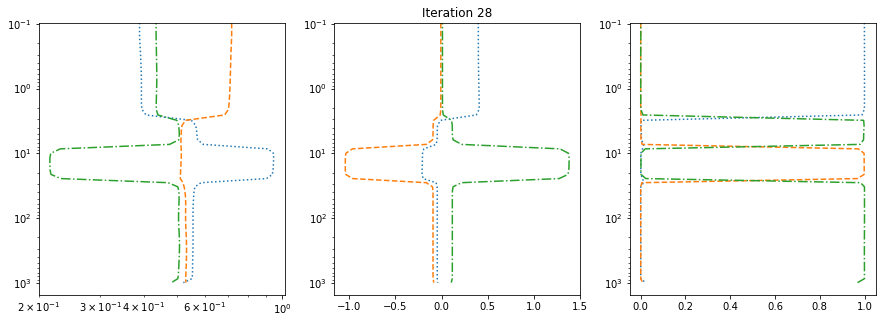

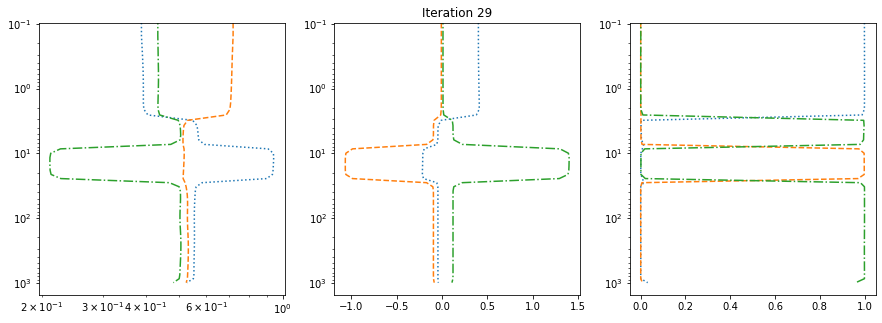

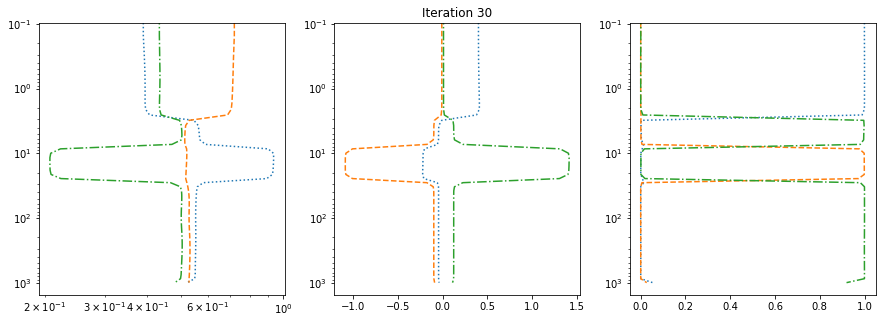

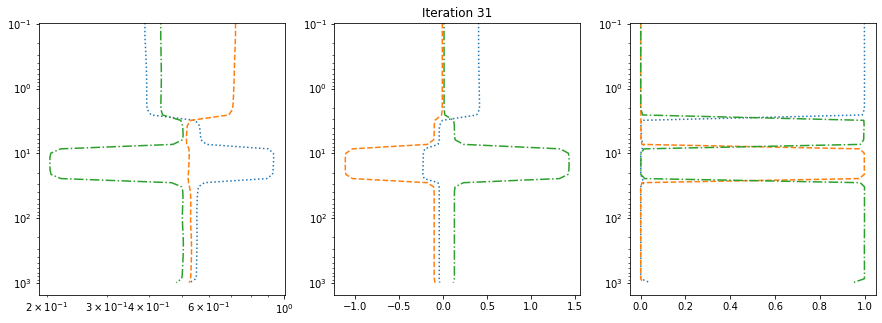

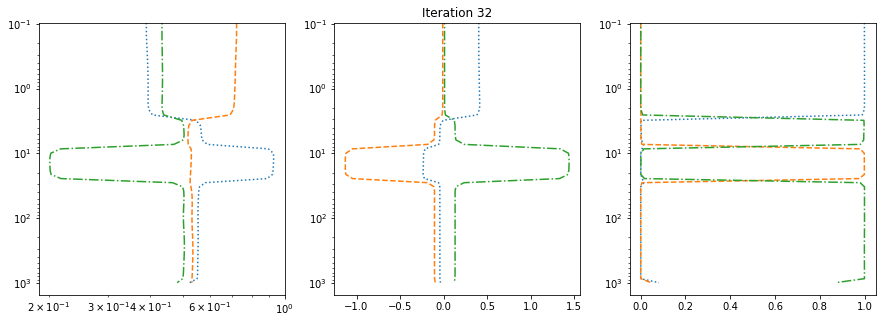

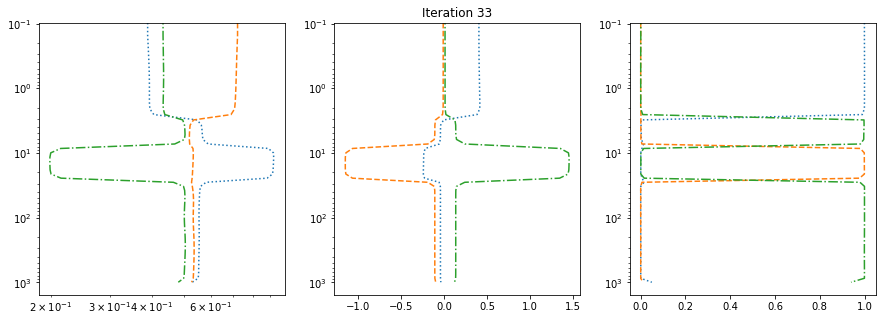

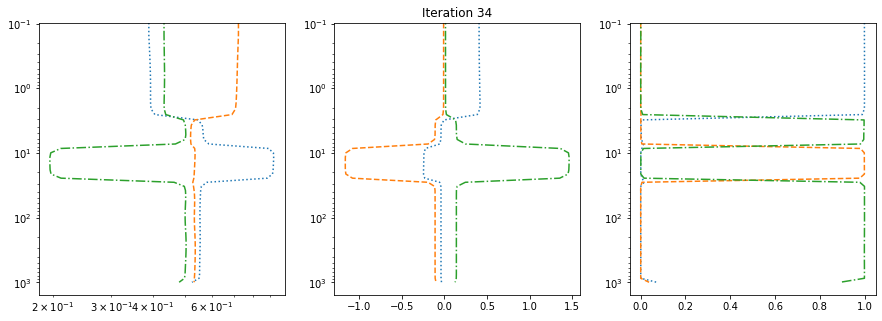

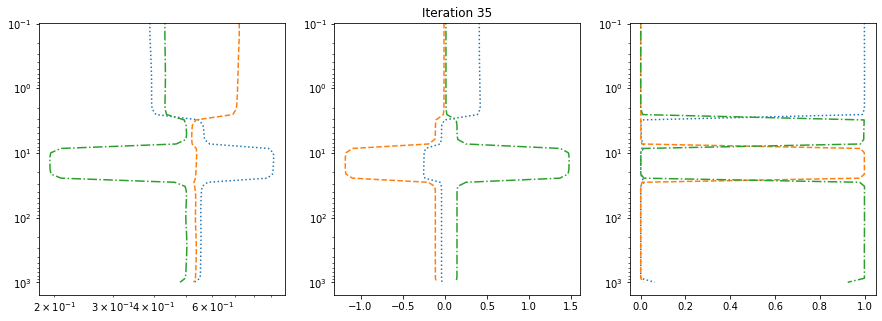

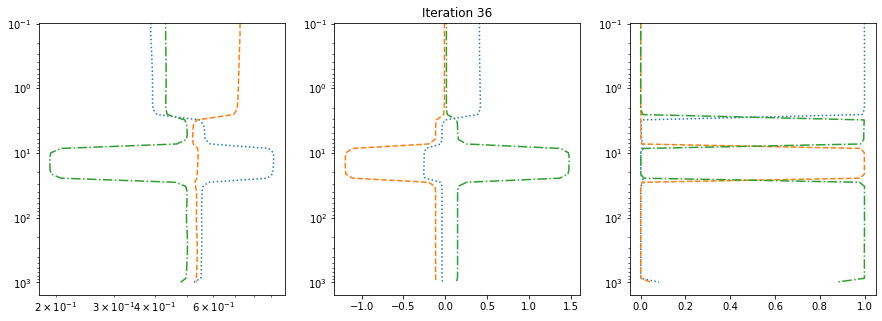

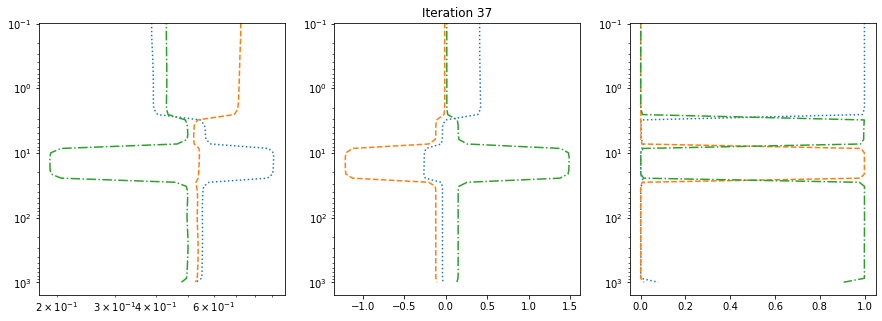

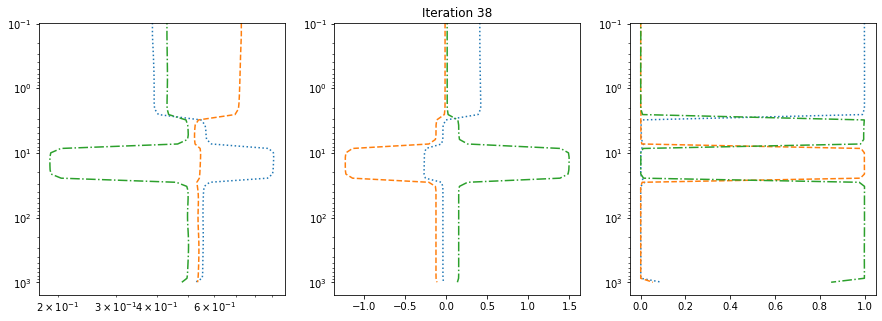

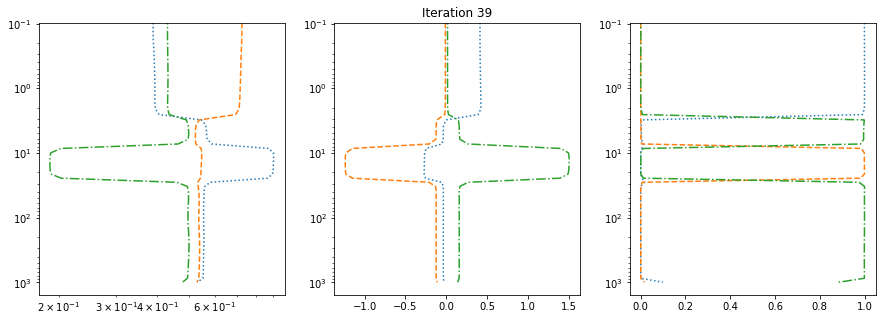

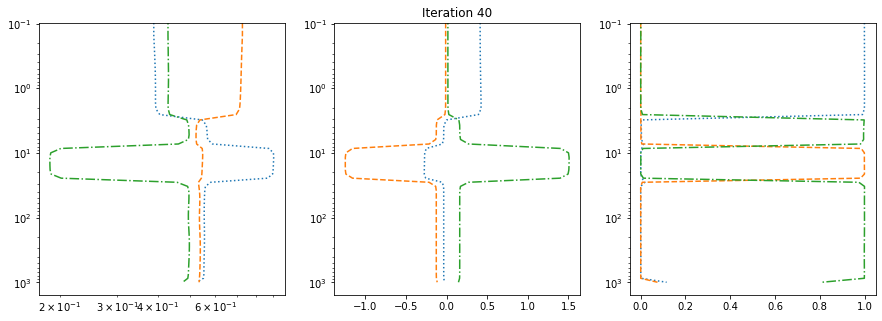

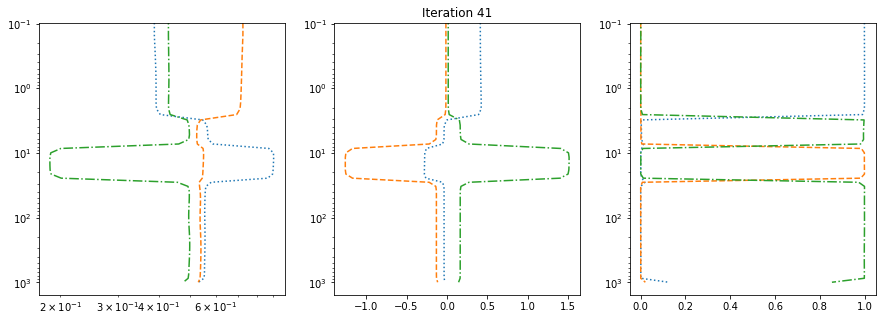

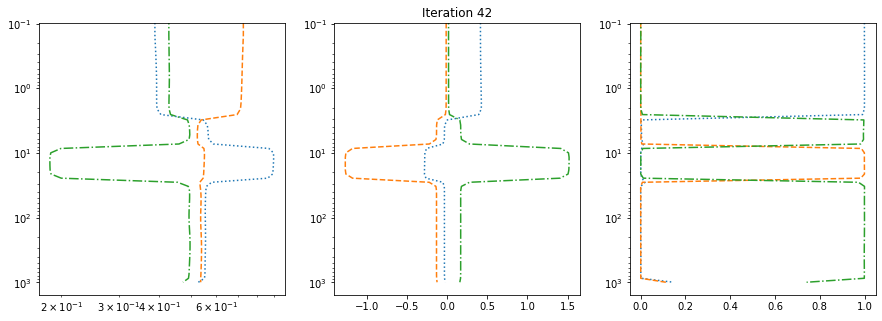

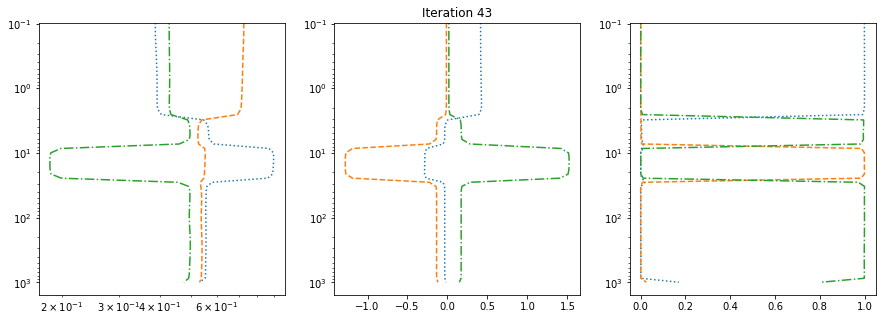

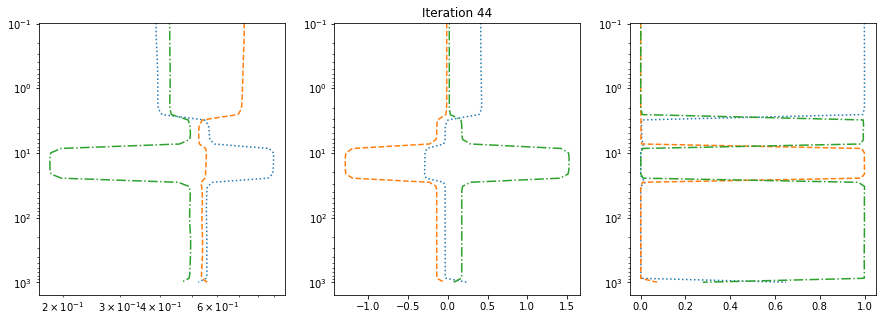

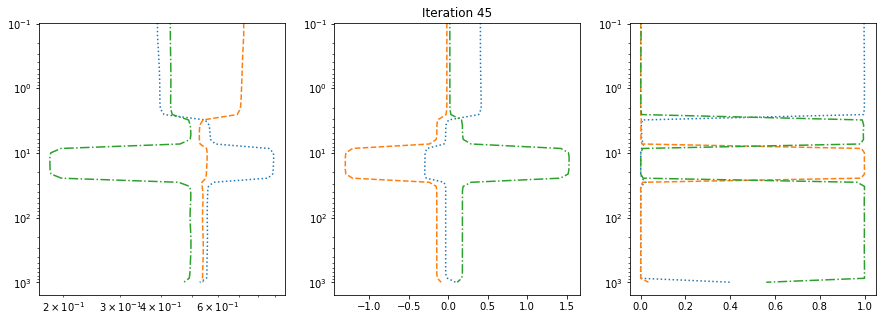

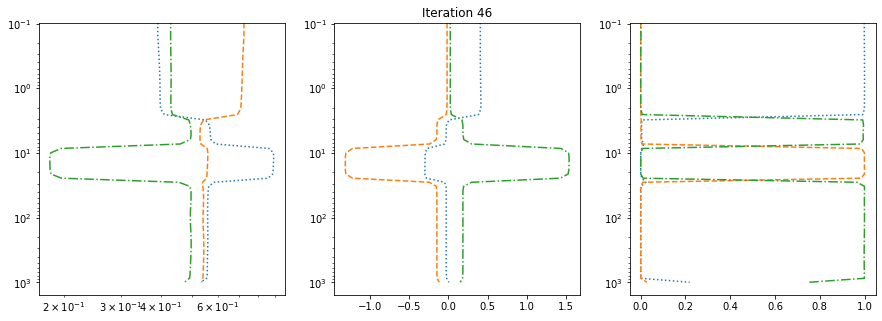

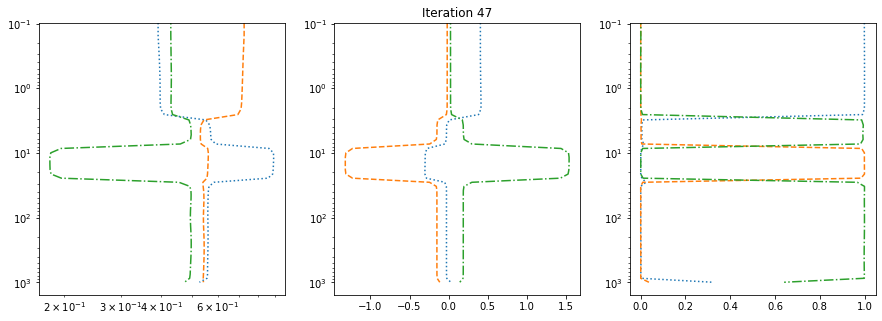

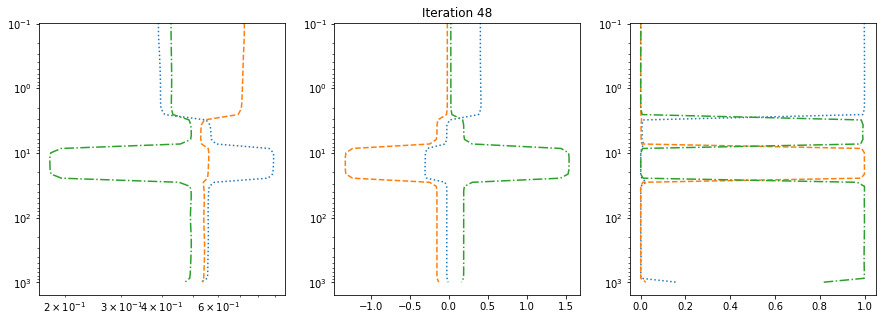

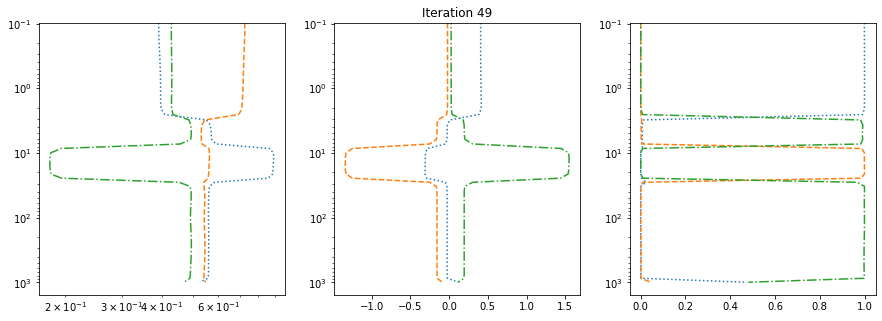

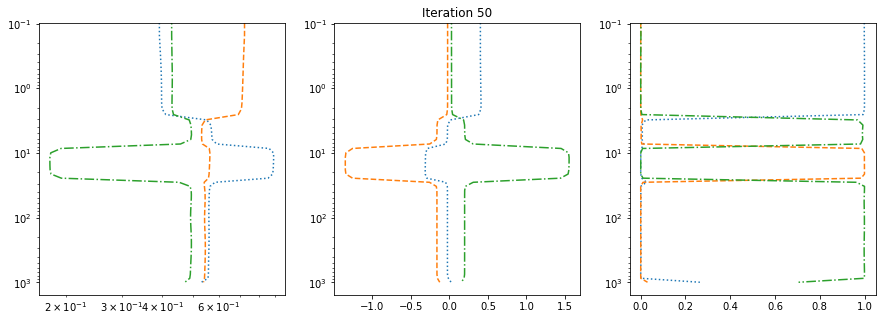

In [57]:
beta = 1.0
lamb = 1000
eta = 0.5

PhiFCM_eff = FCMObjectiveFunction(tk_eff, eta)
u=PhiFCM_eff.updateU(m_eff, v_eff)

PhiFCM = FCMObjectiveFunction(tk, eta, vi=v)
PhiFCM.u = PhiFCM_eff.u

Phi = PhiD+beta*PhiM2+lamb*PhiFCM

vi = v.copy()
xi = np.load(mod_folder + 'beta1_x.npy')
PhiFCM.update_internals()
print(xi.shape)

callback(xi)
phimkm1 = PhiM(xi)
for i in range(50):
    #print('Iteration', i+1)
        
    ###
    # Update v based on xi and effective and u
    v = PhiFCM.updateV(xi, u, eta)
    
    v_eff = v.copy()
    v_eff[:,:3] = np.exp(v_eff[:,:3])
    v_eff = np.c_[eff_anis_trans(*v_eff.T)]
    v_eff[:, :3] = np.log(v_eff[:,:3])
    
    m_eff = xi.reshape(6, n_inv_layers).copy()
    m_eff[:3] = np.exp(m_eff[:3])
    m_eff = np.r_[eff_anis_trans(*m_eff)].reshape(4, n_inv_layers)
    m_eff[:3] = np.log(m_eff[:3])
    m_eff = m_eff.reshape(-1)
    
    norm1 = np.linalg.norm(v-tk)
    norm2 = np.linalg.norm(v_eff-tk_eff)
    print(norm1, norm2)
    if norm2<norm1:
        # Update membership using v_eff
        u = PhiFCM_eff.updateU(m_eff, v_eff)
    else:
        u = PhiFCM.updateU(xi.reshape(6, -1), v)
    PhiFCM.u = u
    
    PhiFCM.update_internals()
    ###
    print(v, PhiFCM(xi.reshape(-1)))
    
    Phi = PhiD+beta*PhiM2+lamb*PhiFCM
    
    out = minimize(Phi, xi.reshape(-1), method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p), tol=1E-2,
                  callback=callback)
    xi = out['x']
    plot_model(xi, PhiFCM.u, i)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    phimk = PhiM(xi)
    rel_phim = np.abs(phimk-phimkm1)/phimkm1
    #print(rel_phim)
    if(rel_phim<1E-4):
        break
    phimkm1 = phimk

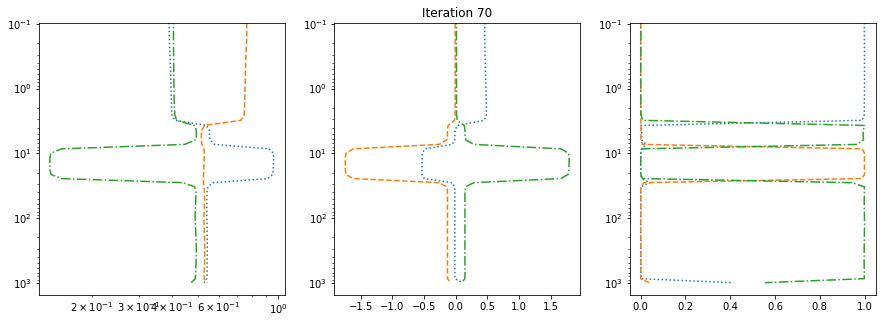

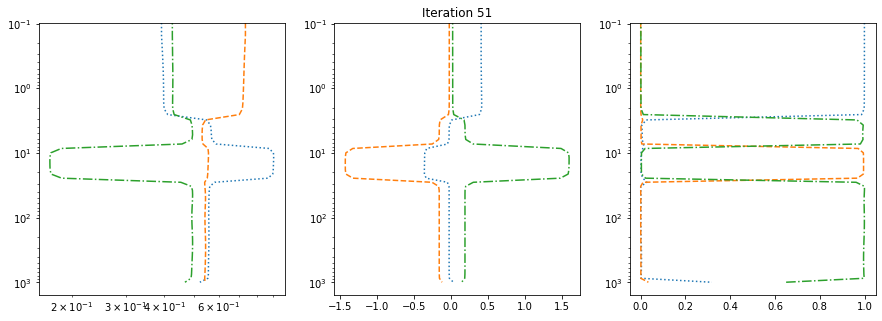

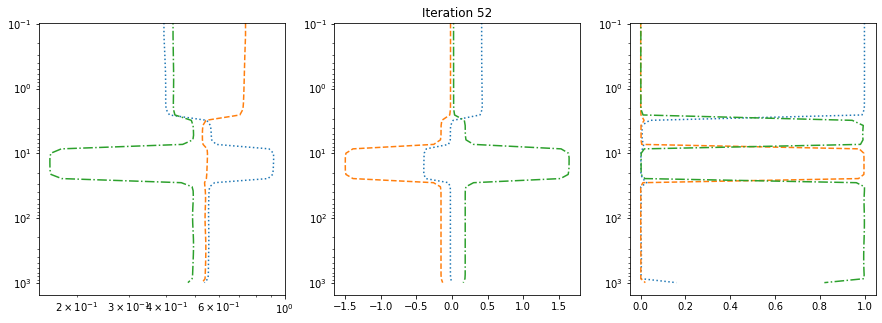

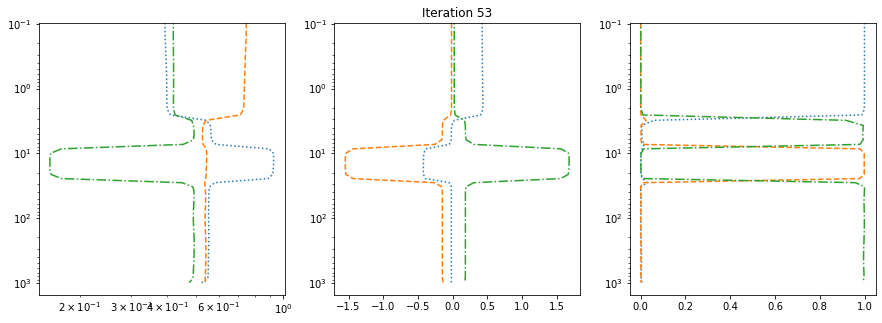

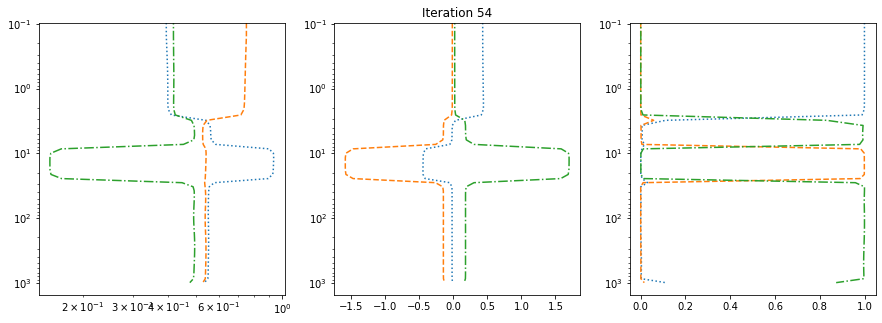

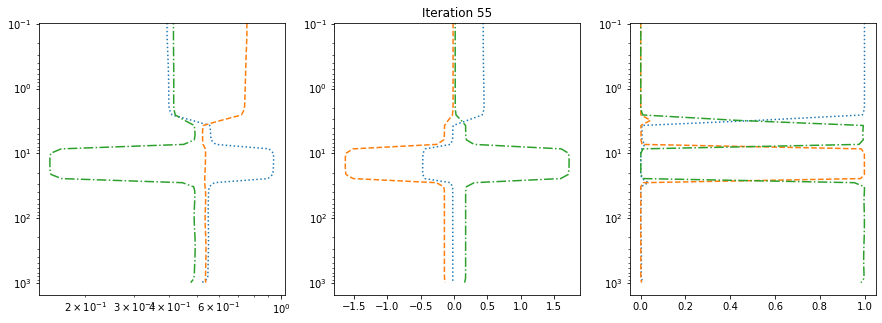

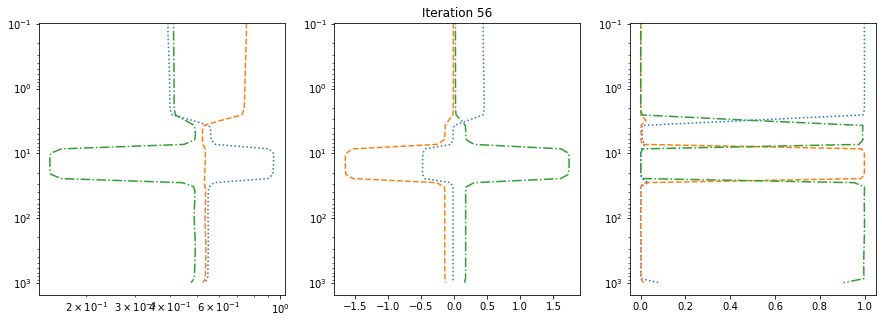

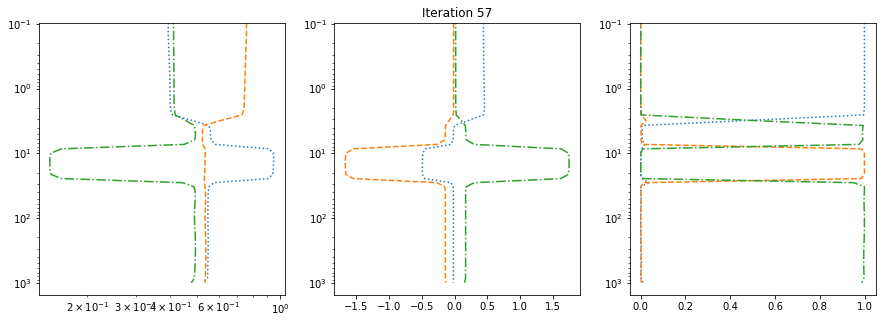

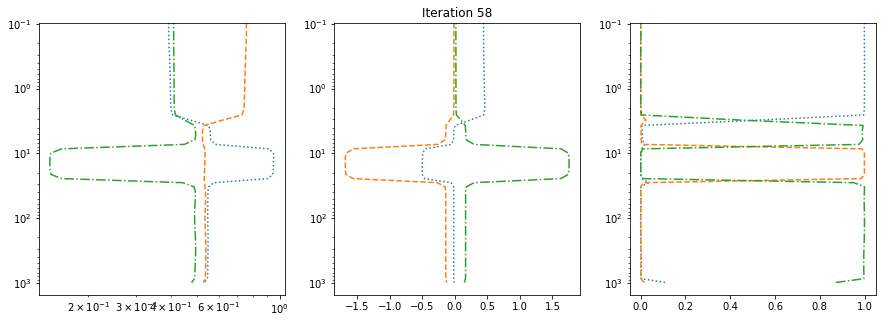

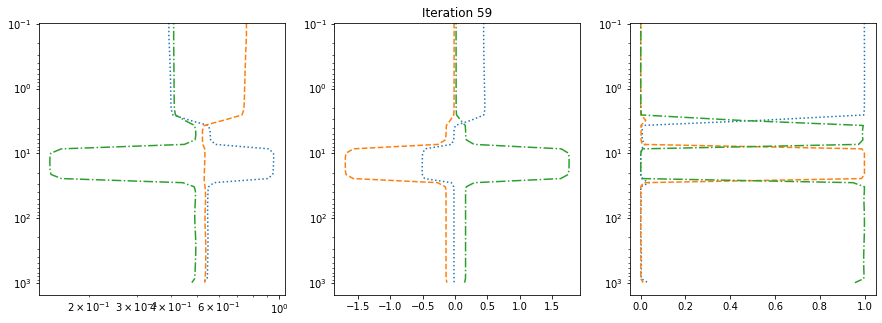

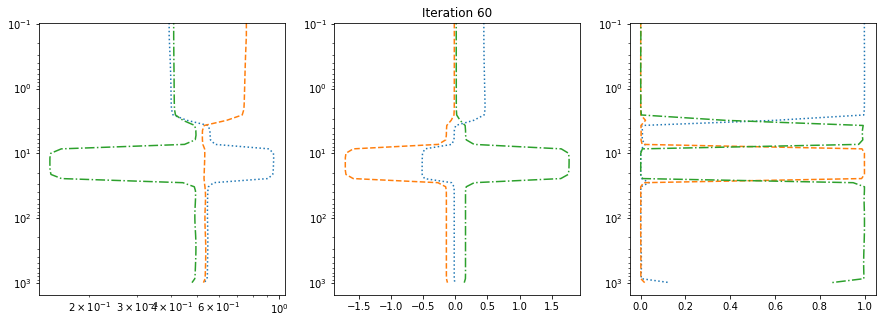

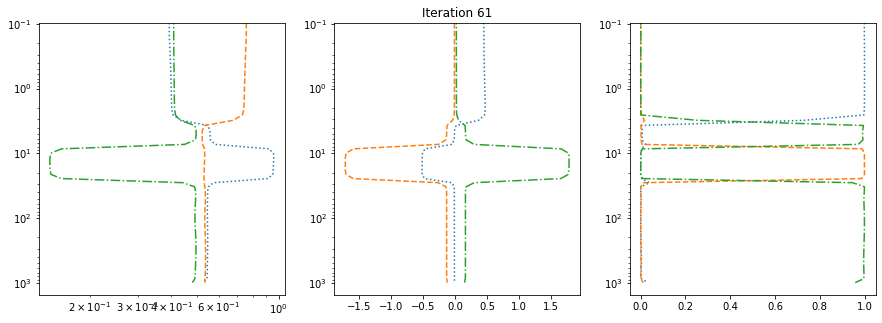

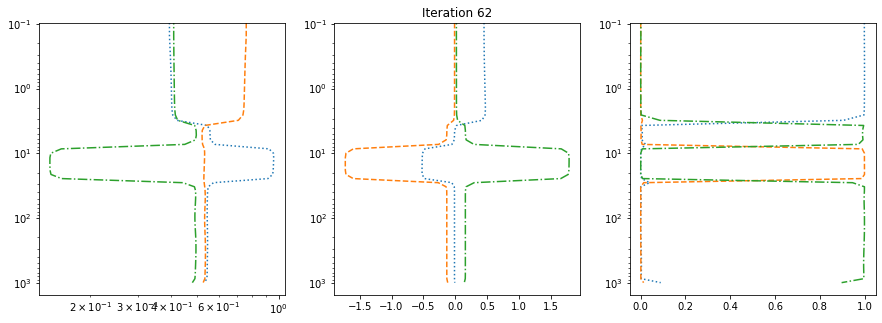

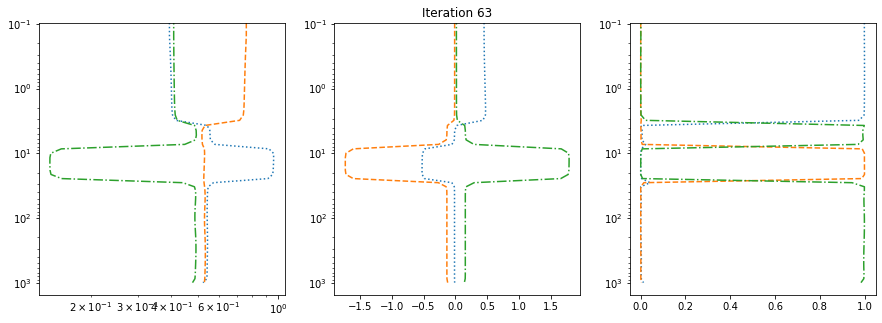

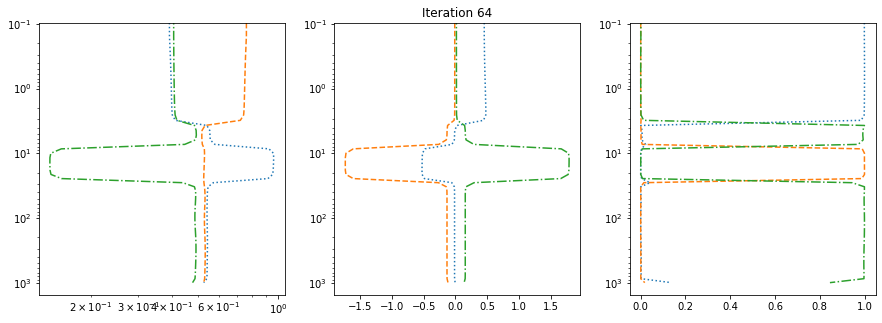

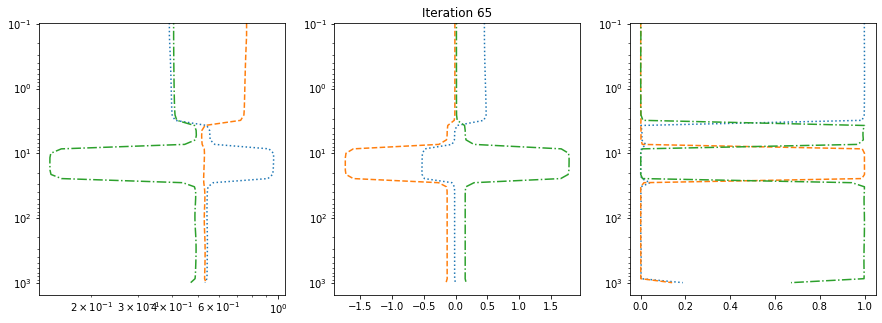

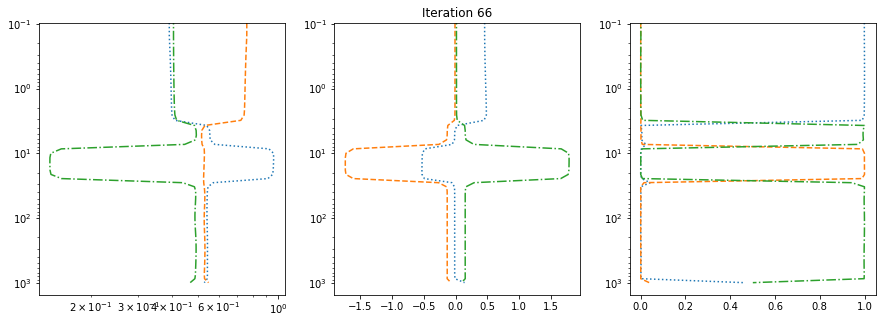

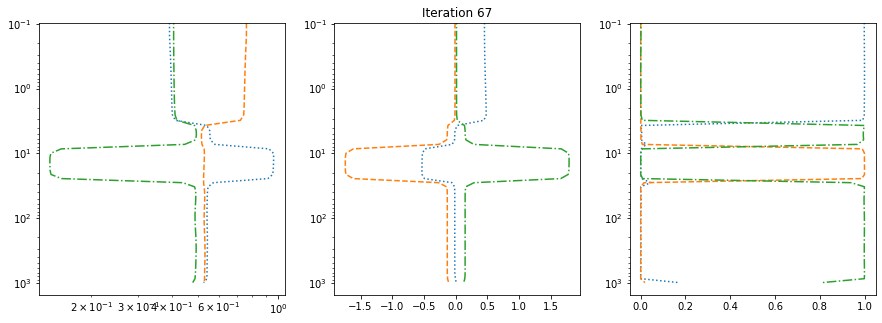

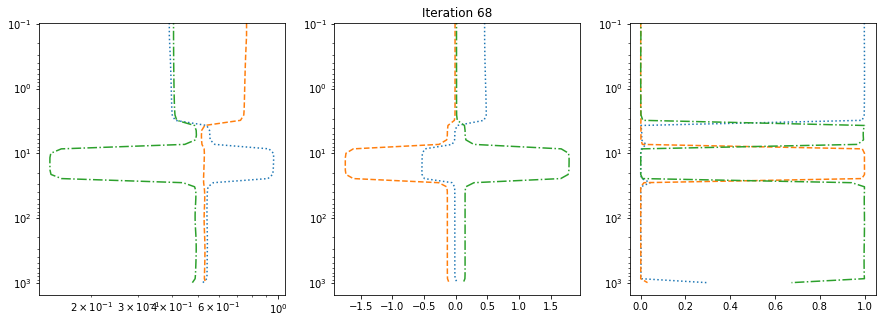

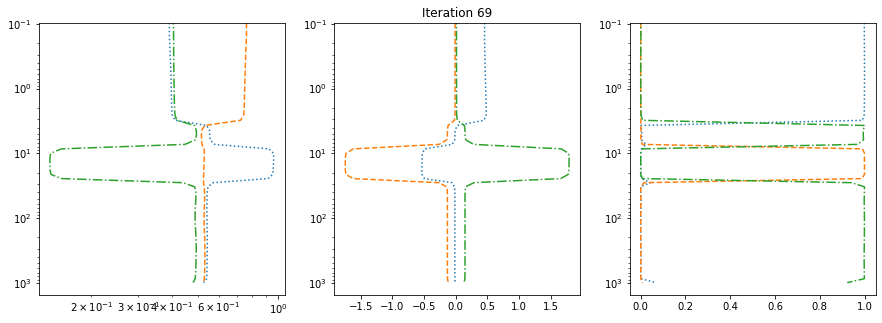

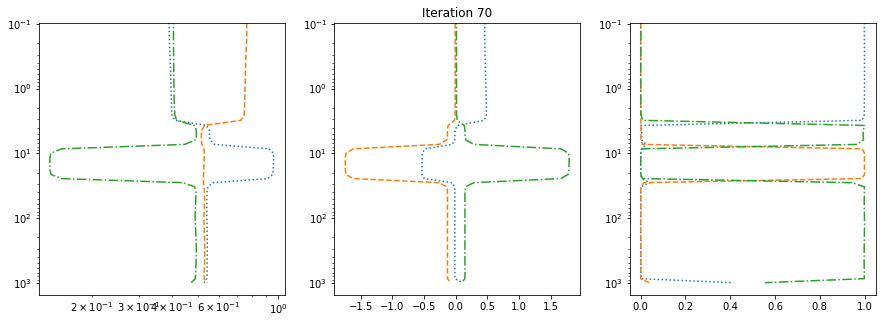

In [58]:
eta = 2.0
for i in range(50,70):
    #print('Iteration', i+1)
        
    ###
    # Update v based on xi and effective and u
    v = PhiFCM.updateV(xi, u, eta)
    
    v_eff = v.copy()
    v_eff[:,:3] = np.exp(v_eff[:,:3])
    v_eff = np.c_[eff_anis_trans(*v_eff.T)]
    v_eff[:, :3] = np.log(v_eff[:,:3])
    
    m_eff = xi.reshape(6, n_inv_layers).copy()
    m_eff[:3] = np.exp(m_eff[:3])
    m_eff = np.r_[eff_anis_trans(*m_eff)].reshape(4, n_inv_layers)
    m_eff[:3] = np.log(m_eff[:3])
    m_eff = m_eff.reshape(-1)
    
    norm1 = np.linalg.norm(v-tk)
    norm2 = np.linalg.norm(v_eff-tk_eff)
    print(norm1, norm2)
    if norm2<norm1:
        # Update membership using v_eff
        u = PhiFCM_eff.updateU(m_eff, v_eff)
    else:
        u = PhiFCM.updateU(xi.reshape(6, -1), v)
    PhiFCM.u = u
    
    PhiFCM.update_internals()
    ###
    print(v, PhiFCM(xi.reshape(-1)))
    
    Phi = PhiD+beta*PhiM2+lamb*PhiFCM
    
    out = minimize(Phi, xi.reshape(-1), method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p), tol=1E-2,
                  callback=callback)
    xi = out['x']
    plot_model(xi, PhiFCM.u, i)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    phimk = PhiM(xi)
    rel_phim = np.abs(phimk-phimkm1)/phimkm1
    #print(rel_phim)
    if(rel_phim<1E-4):
        break
    phimkm1 = phimk

In [59]:
np.save(mod_folder + 'm_fcm_eff',xi)
PhiD(xi)

64.86497224030497

In [62]:
x = np.load(mod_folder + 'beta1_x.npy'); PhiD(xi);
rhoa_pre1 = apparent_conductivity(PhiD.d_pre, A, B, M, N)

x = np.load(mod_folder + 'm_fcm_final_x.npy'); PhiD(xi);
rhoa_pre2 = apparent_conductivity(PhiD.d_pre, A, B, M, N)

x = np.load(mod_folder + 'm_fcm_eff.npy'); PhiD(xi);
rhoa_pre3 = apparent_conductivity(PhiD.d_pre, A, B, M, N)

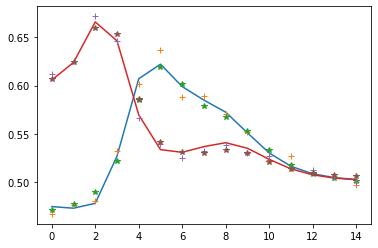

In [63]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(2):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')
    plt.plot(rhoa_pre3[15*i:(i+1)*15],'*')

In [64]:
np.savez(mod_folder + 'data',rhoa_true=rhoa_true, rhoa_obs=rhoa_obs, rhoa_smooth=rhoa_pre1, rhoa_fcm=rhoa_pre2, rhoa_fcm_eff=rhoa_pre3)